<a href="https://colab.research.google.com/github/nkokic/DeepLearning/blob/main/DU-LV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [3]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.8 MB/s eta 0:00:00


In [4]:
import medmnist
from medmnist import BloodMNIST

import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download and load the BloodMNIST dataset
train_dataset = BloodMNIST(split='train', download=True, as_rgb=True, size=28, transform=transform)
test_dataset = BloodMNIST(split='test', download=True, as_rgb=True, size=28, transform=transform)
val_dataset = BloodMNIST(split='val', download=True, as_rgb=True, size=28, transform=transform)

print("BloodMNIST datasets downloaded and loaded.")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

100%|██████████| 35.5M/35.5M [00:18<00:00, 1.88MB/s]


BloodMNIST datasets downloaded and loaded.
Train dataset size: 11959
Test dataset size: 3421
Validation dataset size: 1712


/tmp/ipython-input-2373891269.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


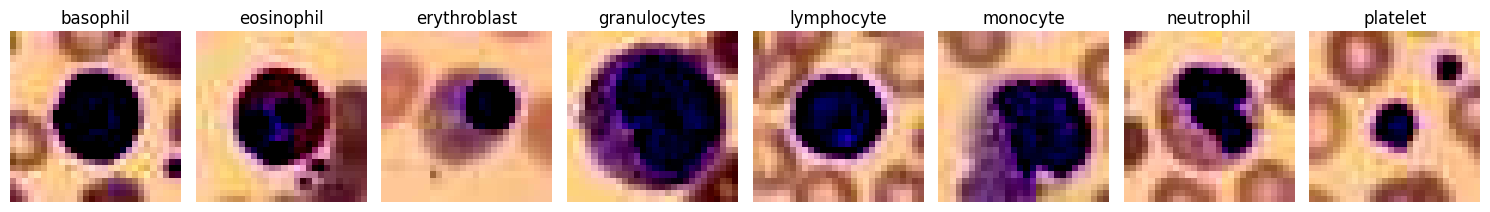

In [22]:
# Show image examples of every class
num_classes = len(train_dataset.info['label'])
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

class_to_image = {}
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label = int(label)
    if label not in class_to_image:
        class_to_image[label] = image
    if len(class_to_image) == num_classes:
        break

# Update class label for display
train_dataset.info['label']['3'] = 'granulocytes'
val_dataset.info['label']['3'] = 'granulocytes'
test_dataset.info['label']['3'] = 'granulocytes'

for i in range(num_classes):
    axes[i].imshow(class_to_image[i].permute(1, 2, 0))
    axes[i].set_title(train_dataset.info['label'][str(i)])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Show count for every class in the whole data set
all_labels = []
for dataset in [train_dataset, test_dataset, val_dataset]:
    all_labels.extend([int(label) for _, label in dataset])

class_counts = np.bincount(all_labels)

print("Class counts in the whole dataset:")
for i in range(len(class_counts)):
    print(f"Class {i} ({train_dataset.info['label'][str(i)]}): {class_counts[i]}")

/tmp/ipython-input-184997941.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.extend([int(label) for _, label in dataset])


Class counts in the whole dataset:
Class 0 (basophil): 1218
Class 1 (eosinophil): 3117
Class 2 (erythroblast): 1551
Class 3 (granulocytes): 2895
Class 4 (lymphocyte): 1214
Class 5 (monocyte): 1420
Class 6 (neutrophil): 3329
Class 7 (platelet): 2348


## Define the cnn model

### Subtask:
Create a simple and customizable CNN model using PyTorch.


**Reasoning**:
Define the `SimpleCNN` class with convolutional, pooling, and fully connected layers, and then instantiate it and move it to the appropriate device.



In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=32 * 7 * 7, out_features=num_classes) # Assuming input size is 28x28

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7) # Flatten the output
        x = self.fc(x)
        return x

# Instantiate the model and move it to the device
num_classes = len(train_dataset.info['label'])
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1568, out_features=8, bias=True)
)


In [27]:
import torch.optim as optim

# Define loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")
print(f"Train loader has {len(train_loader)} batches.")
print(f"Test loader has {len(test_loader)} batches.")
print(f"Validation loader has {len(val_loader)} batches.")

DataLoaders created.
Train loader has 187 batches.
Test loader has 54 batches.
Validation loader has 27 batches.


In [31]:
def train_model(model, optimizer, train_data_loader, val_data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            data_labels = data_labels.squeeze()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

        ## Calculate loss and accuracy for both datasets
        ## Store the accuracies and losses for both datasets
        at, lt = eval_model(model, train_data_loader, loss_module)
        av, lv = eval_model(model, val_data_loader, loss_module)

        loss_train.append(lt)
        loss_val.append(lv)
        acc_train.append(at)
        acc_val.append(av)
        model.train()
    return loss_train, loss_val, acc_train, acc_val

In [32]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    ## Calculate loss for the whole dataset
    loss_run = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            data_labels = data_labels.squeeze()
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds.data, dim=1) # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]
            loss = loss_module(preds, data_labels)
            loss_run += loss.item() * data_labels.size(0)

    acc = true_preds / num_preds
    loss_run /= len(data_loader.dataset)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    print(f"Loss of the model: {loss_run}")

    return acc, loss_run

In [33]:
def visualize_training(train_loss, val_loss, train_acc, val_acc):
  plt.figure(figsize=[4,3])
  plt.plot(train_loss,'r',linewidth=1.0)
  plt.plot(val_loss,'b',linewidth=1.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[4,3])
  plt.plot(train_acc,'r',linewidth=1.0)
  plt.plot(val_acc,'b',linewidth=1.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 92.67%
Loss of the model: 0.19736171867105012
Accuracy of the model: 91.36%
Loss of the model: 0.2625445766705219


Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 93.40%
Loss of the model: 0.1807891169049108
Accuracy of the model: 92.00%
Loss of the model: 0.2544215127965


Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 93.09%
Loss of the model: 0.18967474511593957
Accuracy of the model: 90.83%
Loss of the model: 0.2682525391612097


Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 94.44%
Loss of the model: 0.15908177089572542
Accuracy of the model: 92.41%
Loss of the model: 0.24458162333363684


Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.22%
Loss of the model: 0.14465978742954136
Accuracy of the model: 92.17%
Loss of the model: 0.24286002408121235


Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.28%
Loss of the model: 0.14136267959378776
Accuracy of the model: 91.41%
Loss of the model: 0.25241982644406435


Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.64%
Loss of the model: 0.13173648722931458
Accuracy of the model: 91.94%
Loss of the model: 0.2418682477741598


Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.57%
Loss of the model: 0.13296295721895351
Accuracy of the model: 92.17%
Loss of the model: 0.24581239713686648


Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 95.53%
Loss of the model: 0.12446351490901739
Accuracy of the model: 92.46%
Loss of the model: 0.24241374488745895


Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Accuracy of the model: 94.84%
Loss of the model: 0.14218469918302512
Accuracy of the model: 91.59%
Loss of the model: 0.2585781532052521


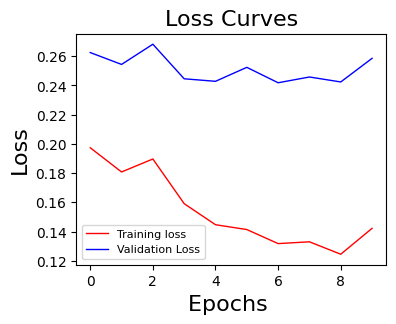

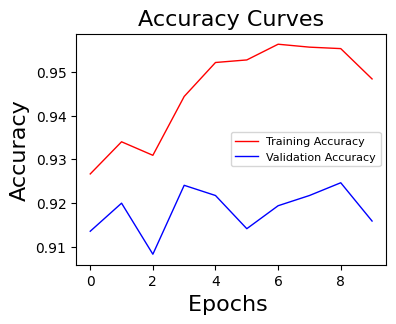

In [34]:
train_loss, val_loss, train_acc, val_acc = train_model(model, optimizer, train_loader, val_loader, loss, 10)
visualize_training(train_loss, val_loss, train_acc, val_acc)

Accuracy of the model on the 3421 test images: 91.11%


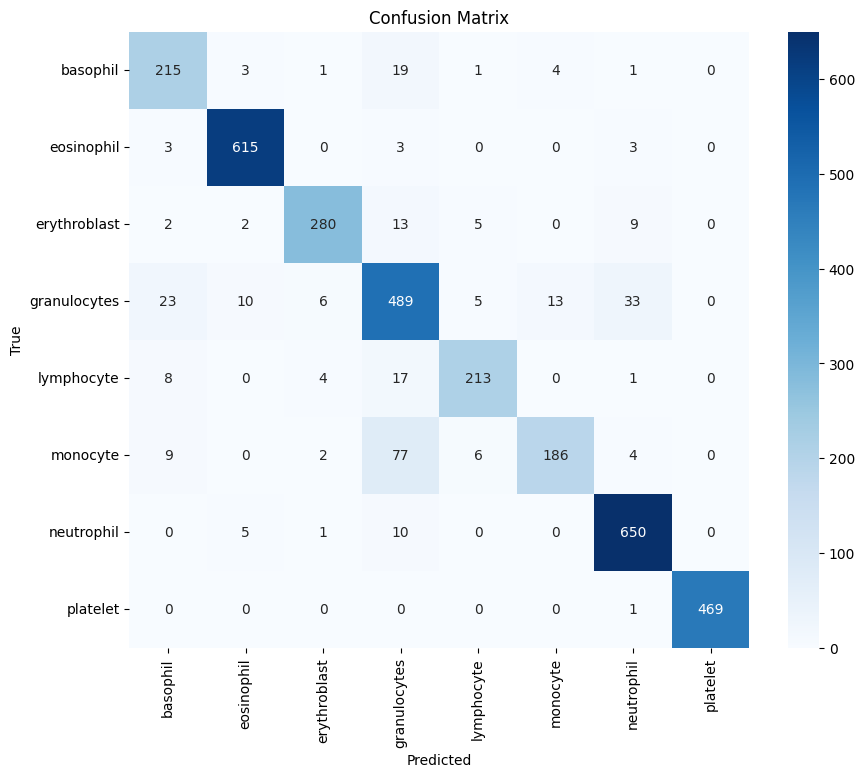

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to be 1D
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


    accuracy = 100 * correct / total
    print(f"Accuracy of the model on the {total} test images: {accuracy:.2f}%")

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.info['label'].values(), yticklabels=train_dataset.info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()